In [195]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_palette('Set2')
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline

import requests
import json
import datetime
import time

from sklearn.preprocessing import KBinsDiscretizer

In [196]:
file = 'CSV_for_EDA.csv'

In [197]:
df = pd.read_csv(file, index_col='date', parse_dates=True)

In [198]:
def clean_up_for_eda(df):

    temp_enc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
    x = temp_enc.fit_transform(df[['apparent_temperature']])
    
    temp = pd.DataFrame(x, index=df.index)
    
    temp = temp.replace({0: 'very_cold',
                    1: 'cold',
                    2: 'warm',
                    3: 'hot',
                    4: 'very_hot'})
    
    df = df.merge(temp, on='date', how='left')
    
    df = df.rename(columns={0: 'temperature_bin'})
    
    df['outside'] = df['outside'].replace({0: 'outside_closed',
                              1: 'outside_open'})

    return df

df = clean_up_for_eda(df)

In [199]:
# Drop Closed Nights for EDA
df = df[df.closed == 0]

In [235]:
df['day_of_week'] = df['day_of_week'].replace({0: 'Mon', 
                       1: 'Tue',
                       2: 'Wed',
                       3: 'Thu',
                       4: 'Fri',
                       5: 'Sat',
                       6: 'Sun'})

In [305]:
df.describe()

,sales,covers,apparent_temperature,humidity,precip_intensity_max,precip_prob,pressure,temperature,month,closed,ppa,year
count,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.0,886.000000,886.000000
mean,16409.752065,222.269752,54.983081,0.636354,0.030307,0.080677,1016.862381,55.940779,5.919865,0.0,74.598745,2017.783296
std,2848.606781,44.980184,20.188837,0.186255,0.070920,0.229752,7.943301,17.891212,3.395130,0.0,7.986504,0.739822
min,9477.750000,138.000000,-5.510000,0.150000,0.000000,0.000000,989.220000,9.160000,1.000000,0.0,54.158571,2017.000000
25%,14175.740000,185.000000,39.202500,0.490000,0.000000,0.000000,1011.882500,40.982500,3.000000,0.0,69.145005,2017.000000
50%,15874.630000,211.000000,55.730000,0.620000,0.001100,0.000000,1016.725000,55.730000,5.000000,0.0,73.678104,2018.000000
75%,18453.712500,256.000000,72.707500,0.780000,0.022025,0.000000,1021.840000,72.120000,9.000000,0.0,78.930313,2018.000000
max,25070.040000,366.000000,96.130000,1.000000,0.668000,1.000000,1039.820000,90.570000,12.000000,0.0,114.740854,2019.000000


In [300]:
df[['sales', 'covers', 'ppa', 'weekend', 'day_of_week']].corr()

,sales,covers,ppa
sales,1.000000,0.859727,0.026941
covers,0.859727,1.000000,-0.477365
ppa,0.026941,-0.477365,1.000000


In [237]:
df['year'] = df.index.year

In [238]:
df.groupby('precip_type')['sales'].aggregate(['mean', 'count'])

,mean,count
precip_type,,
none,16584.467024,425
rain,16378.676791,430
sleet,17417.110000,1
snow,14346.457167,30


In [239]:
df[['sales', 'covers']].resample('Y').mean()

,sales,covers
date,,
2017-12-31,16756.833733,233.986072
2018-12-31,16220.405958,215.491667
2019-12-31,16071.801647,211.694611


In [240]:
df.groupby('outside')[['sales', 'covers', 'ppa']].mean()

,sales,covers,ppa
outside,,,
outside_closed,14693.679337,190.623913,77.304566
outside_open,18262.788345,256.441315,71.676966


In [298]:
(18262.788345  - 14693.679337) / 14693.679337

0.24290097300630928

In [242]:
df2 = pd.melt(df.reset_index(), id_vars='date')
df2.to_csv('df_for_dash.csv')

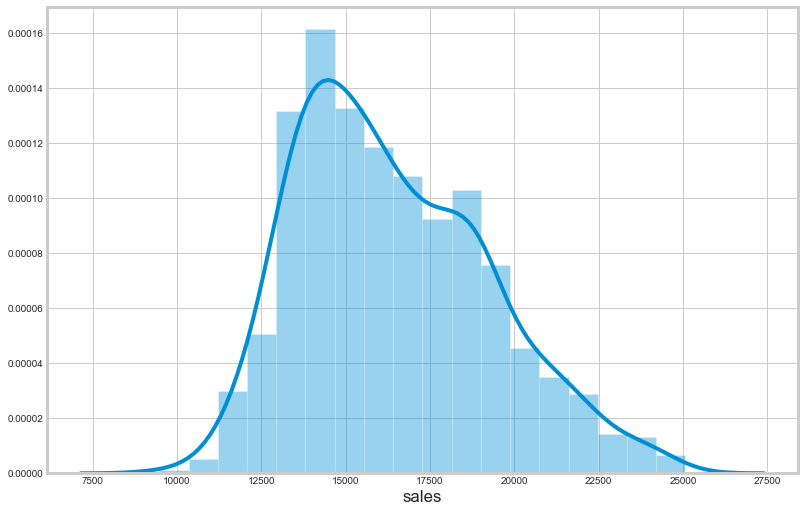

In [243]:
# Histogram of Property Value
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
sns.distplot(df['sales']);

In [244]:
df_ytd = df[df.index.month < 6] # Analyzing Months 1 through 5
dfm_total = df.resample('M').sum()
dfm_avg = df.resample('M').mean()

In [245]:
x = pd.melt(df[['sales', 'covers']].resample('M').mean().reset_index(), id_vars='date')

In [247]:
df.index

DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09',
               '2017-01-10', '2017-01-11',
               ...
               '2019-06-09', '2019-06-10', '2019-06-11', '2019-06-12',
               '2019-06-13', '2019-06-14', '2019-06-15', '2019-06-16',
               '2019-06-17', '2019-06-18'],
              dtype='datetime64[ns]', name='date', length=886, freq=None)

In [248]:
df.groupby(['day_of_week', 'year'])['sales', 'covers', 'ppa'].mean()

sales      covers        ppa
day_of_week year                                     
Fri         2017  18331.323846  248.884615  74.450159
            2018  17568.324231  228.903846  77.123289
            2019  17561.063750  225.625000  78.331094
Mon         2017  15016.671569  211.137255  71.778993
            2018  15165.722549  205.117647  74.536373
            2019  14723.138750  200.708333  74.013498
Sat         2017  19547.539423  270.653846  72.758396
            2018  18500.813846  241.807692  77.030594
            2019  19356.839167  253.458333  77.065795
Sun         2017  16990.837200  251.360000  68.198555
            2018  15989.590980  225.960784  71.353665
            2019  15708.045652  221.260870  71.211773
Thu         2017  16453.993529  223.176471  74.633383
            2018  16094.139412  209.382353  77.926027
            2019  15327.149167  195.333333  78.688495
Tue         2017  15102.658627  211.686275  72.563991
            2018  14853.756078  195.705882  76.577778
            2019  14866.240000  191.666667  77.904430
Wed         2017  15792.712500  220.596154  72.306381
            2018  15317.063558  201.067308  76.931200
            2019  14944.978542  194.208333  77.647003

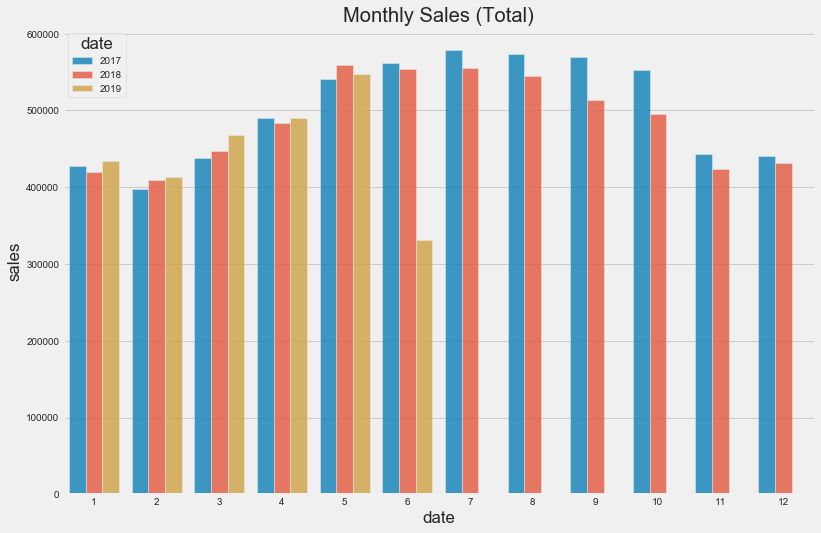

In [249]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))

sns.barplot(x=dfm_total.index.month, y='sales', hue=dfm_total.index.year, data=dfm_total, alpha=0.85, ci=False)
plt.title('Monthly Sales (Total)');

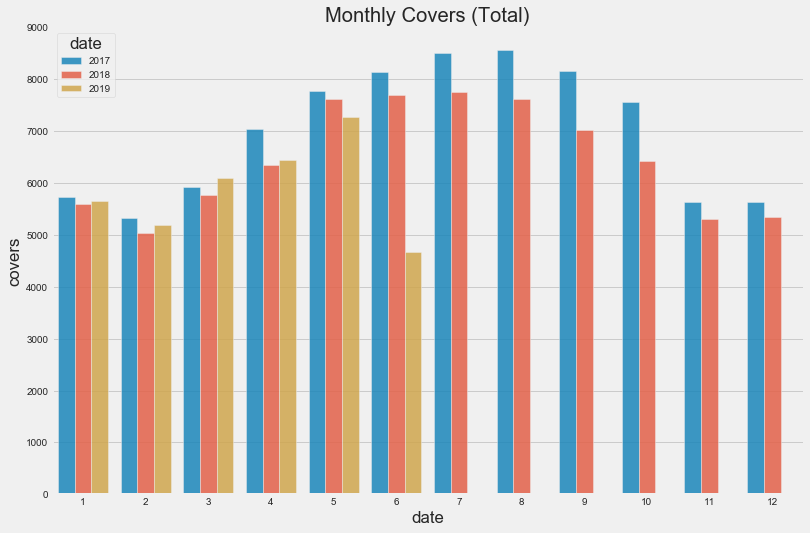

In [250]:
plt.figure(figsize=(12,8))
sns.barplot(x=dfm_total.index.month, y='covers', hue=dfm_total.index.year, data=dfm_total, alpha=0.85, ci=False)
plt.title('Monthly Covers (Total)');

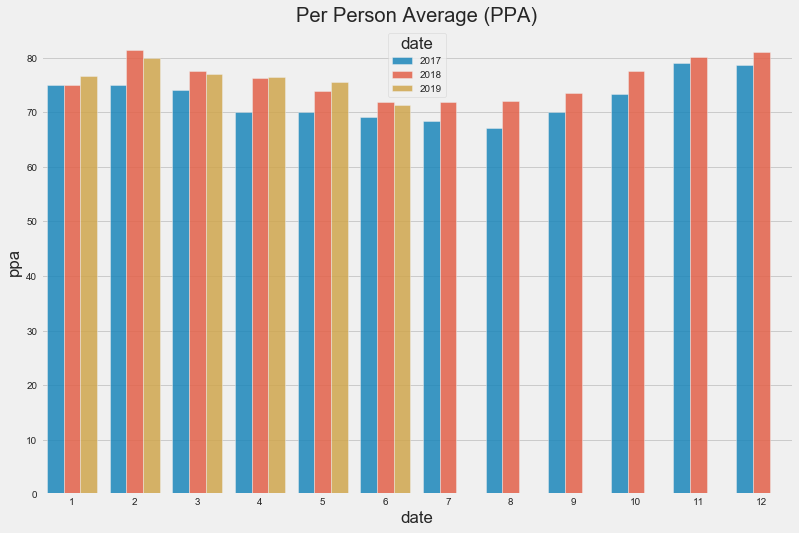

In [251]:
plt.figure(figsize=(12,8))
sns.barplot(x=dfm_avg.index.month, y='ppa', hue=dfm_avg.index.year, data=dfm_avg, alpha=0.85, ci=False)
plt.title('Per Person Average (PPA)');

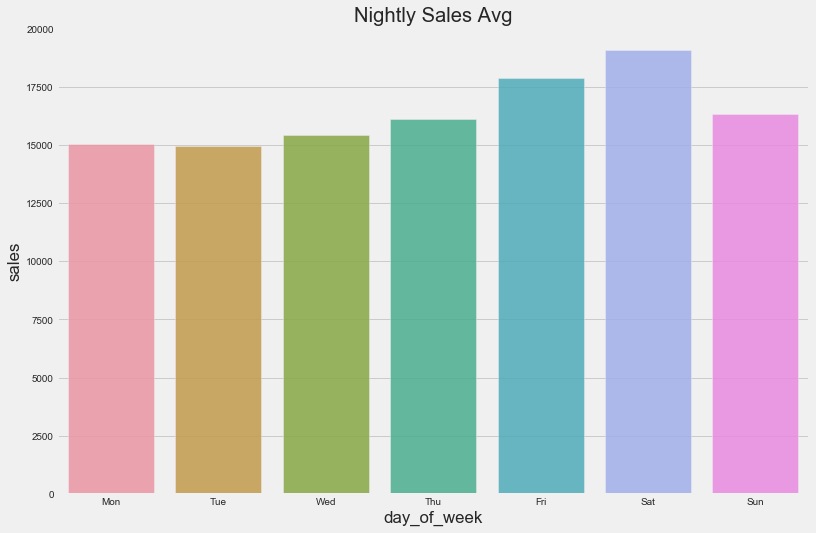

In [307]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
sns.barplot(x='day_of_week', y='sales', data=df, alpha=0.85, ci=False)
plt.title('Nightly Sales Avg');

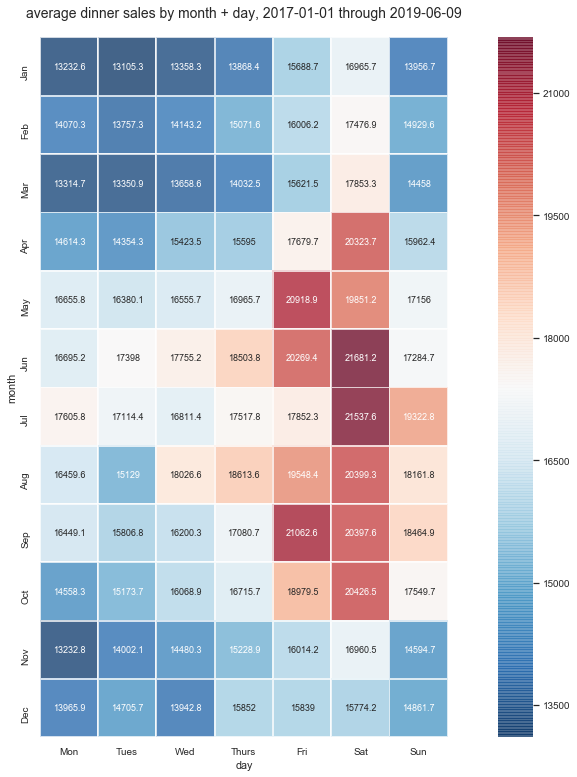

In [253]:
def sales_heatmap(df, start_date, end_date):
    
    sns.set_style('whitegrid')
    temp_df = df[(df.index > start_date) & (df.index < end_date)]
    
    matrix = temp_df.groupby([temp_df.index.month, temp_df.index.dayofweek]).agg({'sales': 'mean'})
    matrix = matrix.rename_axis(['month', 'day'])
    temp_df = matrix.unstack(level=1)

    plt.figure(figsize=(16,12))
    sns.set(font_scale=0.9)
    sns.set_style('whitegrid')
    sns.heatmap(temp_df, square=True, linewidths=0.75, annot=True, annot_kws={"size": 9}, fmt='g', 
                cmap='RdBu_r', alpha=0.75, yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                xticklabels=['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
    plt.ylabel('month')
    plt.xlabel('day')
    plt.title(f'average dinner sales by month + day, {start_date} through {end_date}',size=14, pad=20)
    plt.show();
    
sales_heatmap(df, '2017-01-01', '2019-06-09')

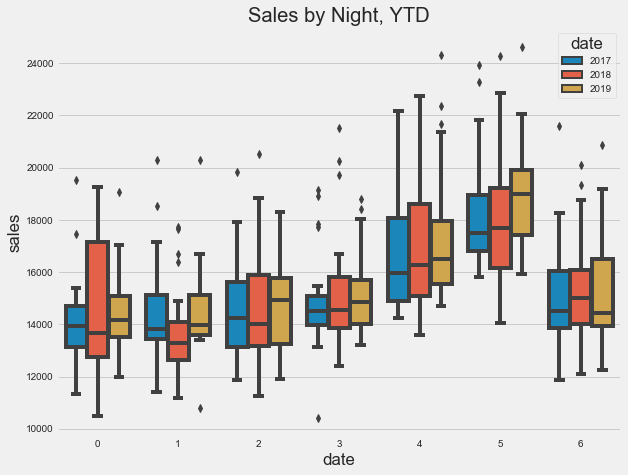

In [254]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9,7))
sns.boxplot(x=df_ytd.index.dayofweek,
               y=df_ytd.sales,
               hue=df_ytd.index.year,
               data=df_ytd
                );

plt.title('Sales by Night, YTD');

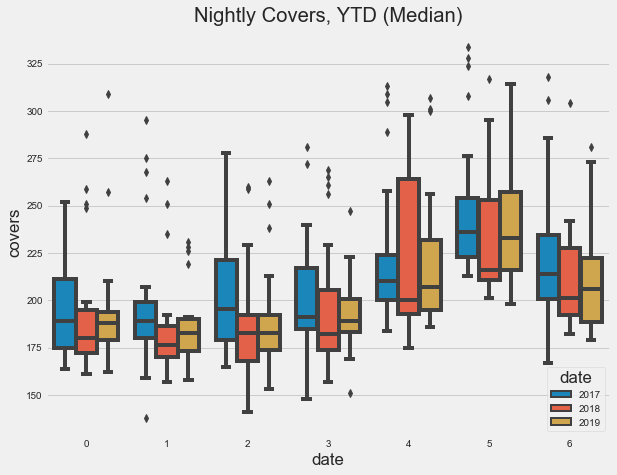

In [255]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9,7))
sns.boxplot(x=df_ytd.index.dayofweek,
               y='covers',
               hue=df_ytd.index.year,
               data=df_ytd
                );

plt.title('Nightly Covers, YTD (Median)');

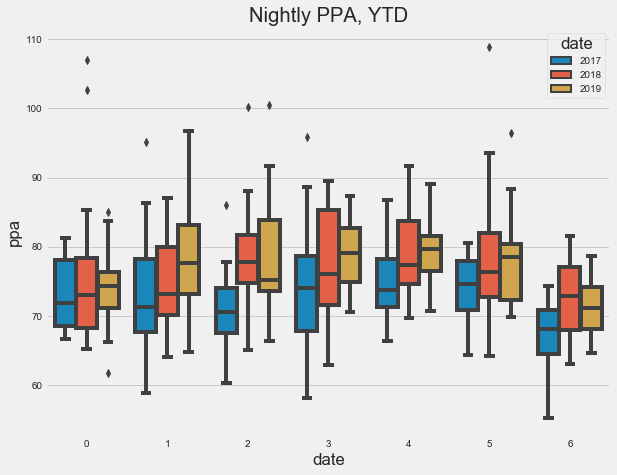

In [256]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9,7))
sns.boxplot(x=df_ytd.index.dayofweek,
               y='ppa',
               hue=df_ytd.index.year,
               data=df_ytd
                );

plt.title('Nightly PPA, YTD');

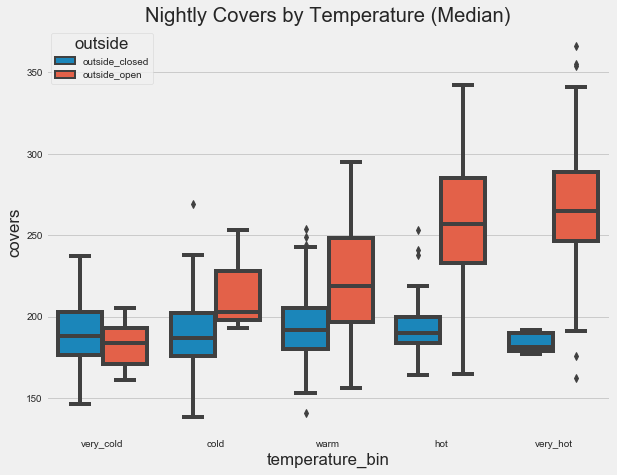

In [257]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9,7))
sns.boxplot(x='temperature_bin',
               y='covers',
               hue='outside',
               data=df,
               order=['very_cold', 'cold', 'warm', 'hot', 'very_hot']
                );

plt.title('Nightly Covers by Temperature (Median)');

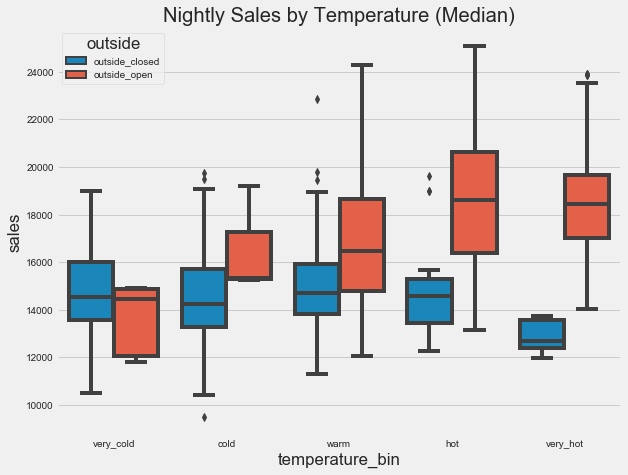

In [258]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9,7))
sns.boxplot(x='temperature_bin',
               y='sales',
               hue='outside',
               data=df,
               order=['very_cold', 'cold', 'warm', 'hot', 'very_hot']
                );

plt.title('Nightly Sales by Temperature (Median)');

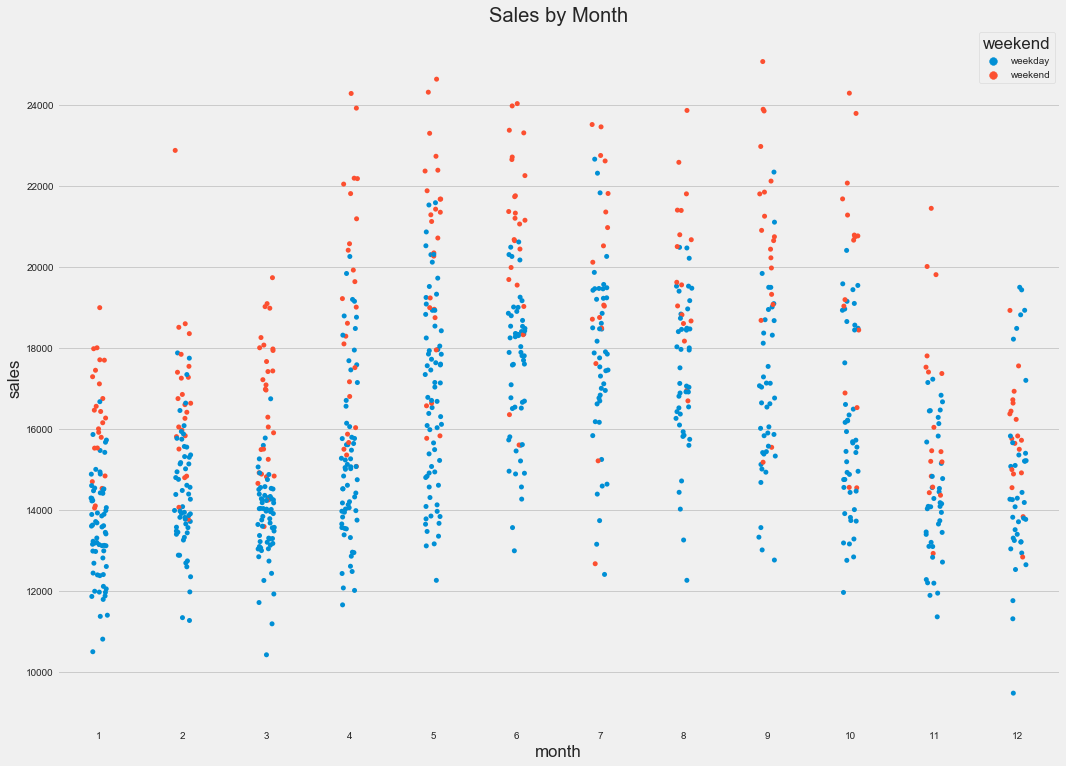

In [268]:
df['weekend'] = np.where((df['day_of_week'] == 'Fri') | (df['day_of_week'] == 'Sat'), 'weekend', 'weekday')

plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,12))
sns.stripplot(x='month',
               y='sales',
               hue='weekend',
               data=df
                );

plt.title('Sales by Month');

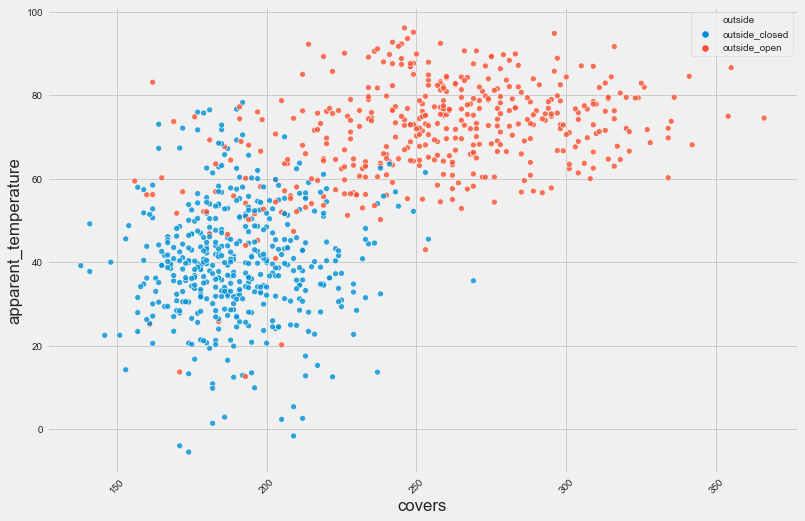

In [269]:
def scatter_plot(col_1, col_2, col_hue, data):
    
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=col_1, y=col_2, hue=col_hue, data=data, alpha=.8)
    plt.xticks(rotation=45)
    plt.show();
    
scatter_plot('covers', 'apparent_temperature', 'outside', df)

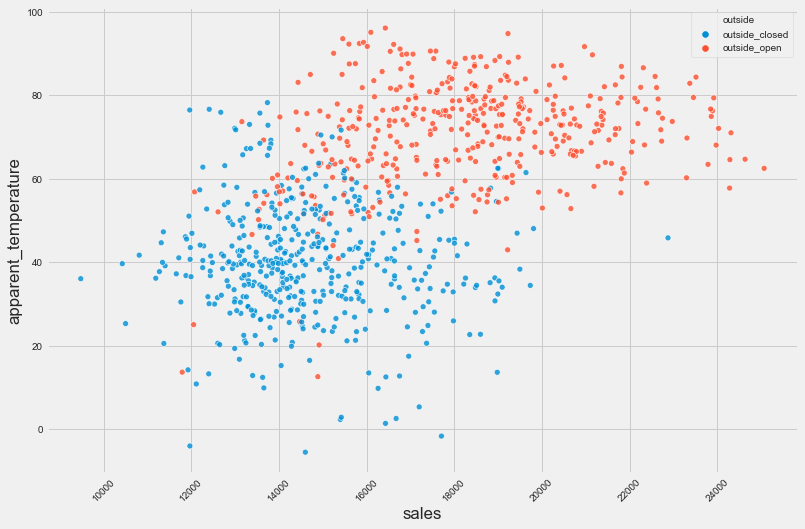

In [261]:
def scatter_plot(col_1, col_2, col_hue, data):
    
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=col_1, y=col_2, hue=col_hue, data=data, alpha=.8)
    plt.xticks(rotation=45)
    plt.show();
    
scatter_plot('sales', 'apparent_temperature', 'outside', df)

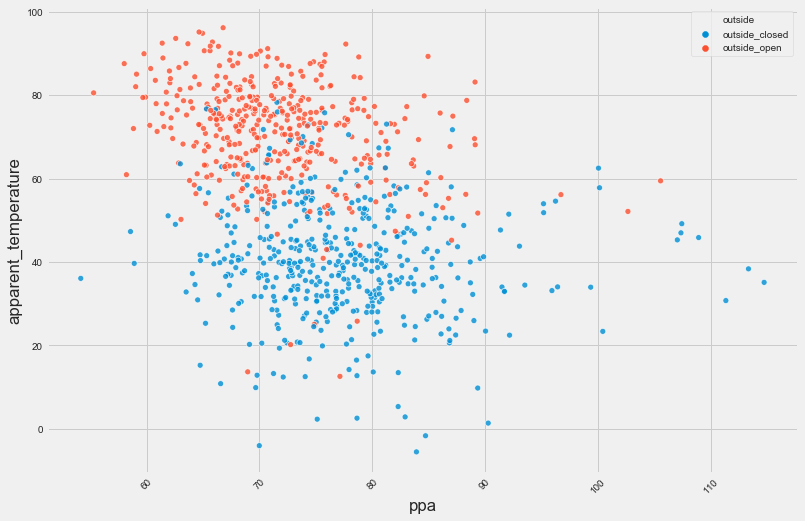

In [262]:
def scatter_plot(col_1, col_2, col_hue, data):
    
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=col_1, y=col_2, hue=col_hue, data=data, alpha=.8)
    plt.xticks(rotation=45)
    plt.show();
    
scatter_plot('ppa', 'apparent_temperature', 'outside', df)

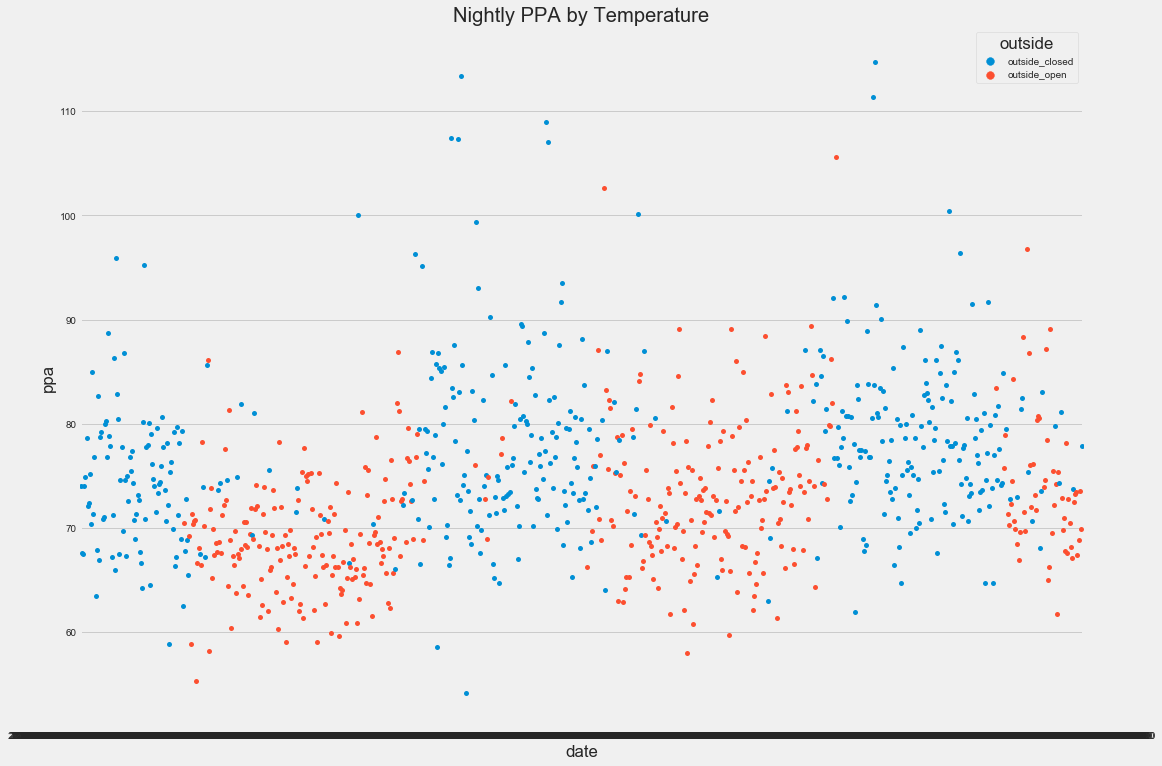

In [263]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,12))

sns.stripplot(x=df.index,
               y='ppa',
               hue='outside',
               data=df
                )

plt.title('Nightly PPA by Temperature');

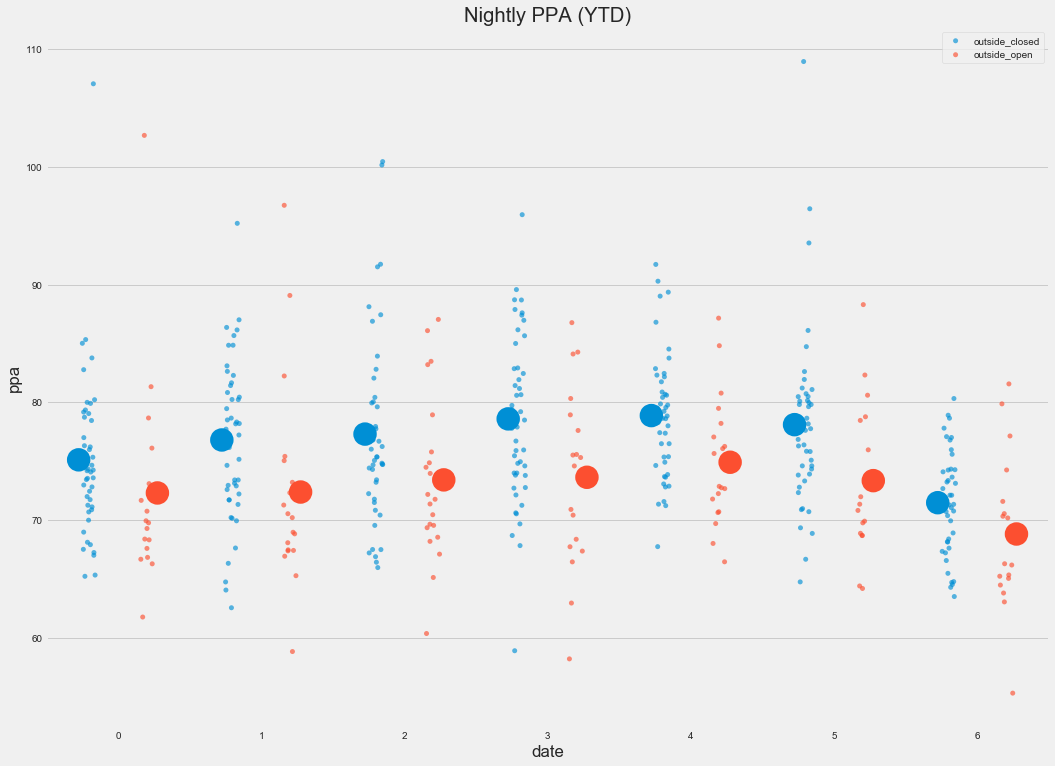

In [264]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,12))
sns.stripplot(x=df_ytd.index.dayofweek,
               y='ppa',
               hue='outside',
               data=df_ytd,
               dodge=0.35,
               alpha=0.65
                );

sns.pointplot(x=df_ytd.index.dayofweek,
               y='ppa',
               hue='outside',
               data=df_ytd,
               dodge=0.55,
               alpha=0.75,
               join=False,
               ci=None
                );


plt.legend(['outside_closed', 'outside_open'])
plt.title('Nightly PPA (YTD)');

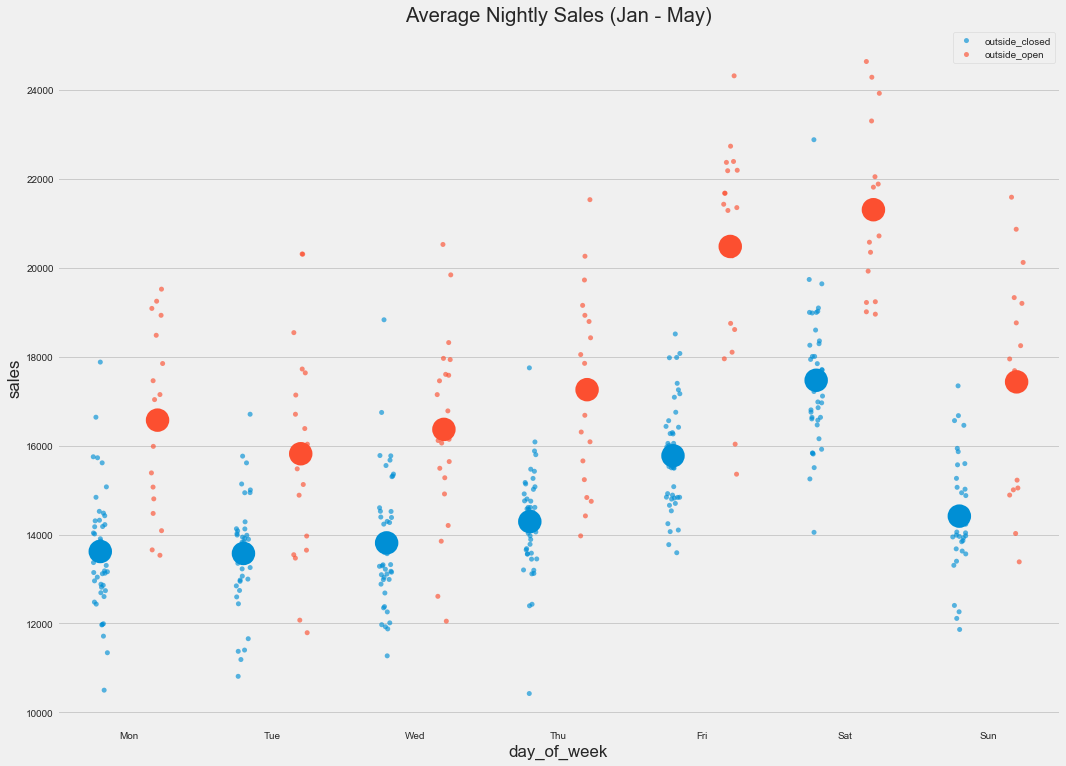

In [297]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,12))
sns.stripplot(x='day_of_week',
               y='sales',
               hue='outside',
               data=df_ytd,
               dodge=0.05,
               alpha=0.65
                );

sns.pointplot(x='day_of_week',
               y='sales',
               hue='outside',
               data=df_ytd,
               dodge=0.40,
               alpha=0.75,
               join=False,
               ci=None
                );


plt.legend(['outside_closed', 'outside_open'])
plt.title('Average Nightly Sales (Jan - May)');

In [266]:
df_ytd.head()

,sales,covers,outside,apparent_temperature,humidity,precip_intensity_max,precip_max_time,precip_prob,precip_type,pressure,summary,temperature,day_of_week,month,closed,ppa,temperature_bin,year,weekend
date,,,,,,,,,,,,,,,,,,,
2017-01-02,12814.84,173.0,outside_closed,35.58,0.92,0.0242,03:00PM,0.79,rain,1027.98,rain,39.06,Mon,1,0,74.074220,cold,2017,weekday
2017-01-03,12442.11,184.0,outside_closed,41.50,0.94,0.0913,05:00PM,0.77,rain,1000.08,rain,43.19,Tue,1,0,67.620163,cold,2017,weekday
2017-01-04,11877.64,176.0,outside_closed,36.81,0.40,0.0176,12:00AM,0.00,rain,1002.55,clear-night,42.29,Wed,1,0,67.486591,cold,2017,weekday
2017-01-05,14057.79,190.0,outside_closed,27.11,0.48,0.0000,05:01AM,0.00,none,1014.61,cloudy,31.36,Thu,1,0,73.988368,very_cold,2017,weekday
2017-01-06,14531.97,194.0,outside_closed,24.74,0.48,0.0019,12:00PM,0.00,snow,1022.80,partly-cloudy-night,29.42,Fri,1,0,74.907062,very_cold,2017,weekend


In [270]:
df_ytd.head()

,sales,covers,outside,apparent_temperature,humidity,precip_intensity_max,precip_max_time,precip_prob,precip_type,pressure,summary,temperature,day_of_week,month,closed,ppa,temperature_bin,year,weekend
date,,,,,,,,,,,,,,,,,,,
2017-01-02,12814.84,173.0,outside_closed,35.58,0.92,0.0242,03:00PM,0.79,rain,1027.98,rain,39.06,Mon,1,0,74.074220,cold,2017,weekday
2017-01-03,12442.11,184.0,outside_closed,41.50,0.94,0.0913,05:00PM,0.77,rain,1000.08,rain,43.19,Tue,1,0,67.620163,cold,2017,weekday
2017-01-04,11877.64,176.0,outside_closed,36.81,0.40,0.0176,12:00AM,0.00,rain,1002.55,clear-night,42.29,Wed,1,0,67.486591,cold,2017,weekday
2017-01-05,14057.79,190.0,outside_closed,27.11,0.48,0.0000,05:01AM,0.00,none,1014.61,cloudy,31.36,Thu,1,0,73.988368,very_cold,2017,weekday
2017-01-06,14531.97,194.0,outside_closed,24.74,0.48,0.0019,12:00PM,0.00,snow,1022.80,partly-cloudy-night,29.42,Fri,1,0,74.907062,very_cold,2017,weekend


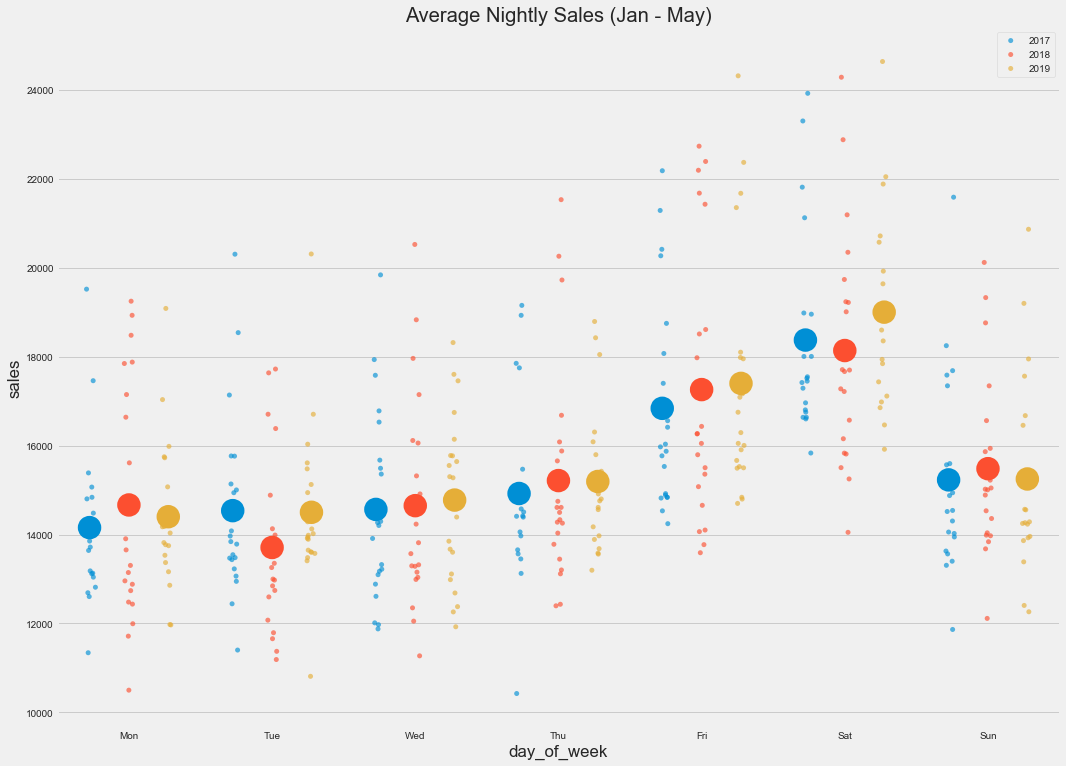

In [302]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,12))
sns.stripplot(x='day_of_week',
               y='sales',
               hue='year',
               data=df_ytd,
               dodge=0.35,
               alpha=0.65
                );

sns.pointplot(x='day_of_week',
               y='sales',
               hue='year',
               data=df_ytd,
               dodge=0.55,
               alpha=0.75,
               join=False,
               ci=None
                );


plt.legend(['2017', '2018', '2019'])
plt.title('Average Nightly Sales (Jan - May)');

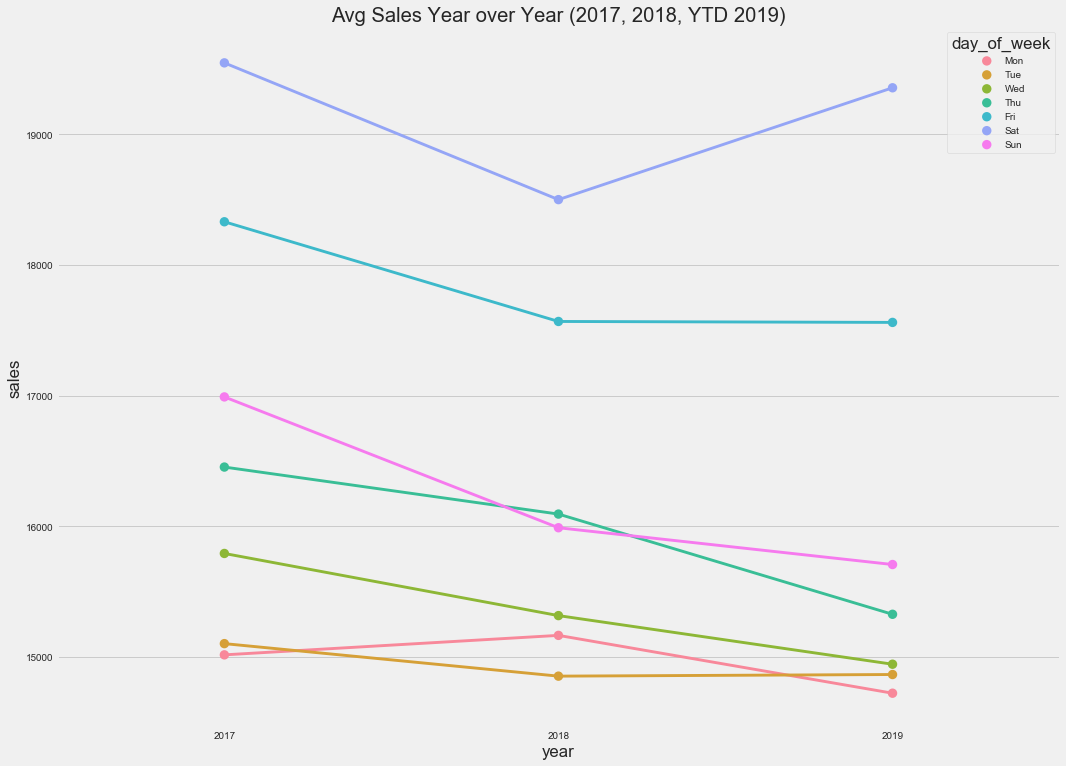

In [275]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,12))

sns.pointplot(x='year',
               y='sales',
               hue='day_of_week',
               data=df,
               alpha=0.75,
               join=True,
               ci=False,
               scale=0.4
                )

plt.title('Avg Sales Year over Year (2017, 2018, YTD 2019)');